# Problem Set 4
## Ying Sun

## 1. Some income data, lognormal distribution, and hypothesis testing

(a) Plot a histogram of percentages of the income.txt data with 30 bins. Make sure that the bins are weighted using the normed=True option. Make sure your plot has correct x-axis and y-axis labels as well as a plot title.

In [1]:
import numpy as np
import scipy.stats as sts
import requests
import warnings
warnings.filterwarnings("ignore")

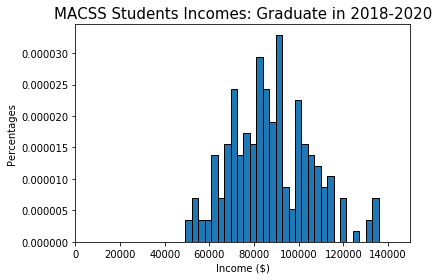

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
# load data
incomes = np.loadtxt('incomes.txt')
# plot histogram
count, bins, ignored = plt.hist(incomes, 30, edgecolor='black', normed=True)
plt.title('MACSS Students Incomes: Graduate in 2018-2020', fontsize=15)
plt.xlabel('Income ($)')
plt.ylabel('Percentages')
plt.xlim([0, 150000])
plt.show()

(b) Plot the lognormal PDF f(x|μ = 11.0,σ = 0.5) for 0 ≤ x ≤ 150,000. What is the value of the log likelihood value for this parameterization of the distribution and given this data?

In [3]:
def truncnorm_pdf(xvals, mu, sigma, cutoff):
    '''
    --------------------------------------------------------------------
    Generate pdf values from the truncated normal pdf with mean mu and
    standard deviation sigma. If the cutoff is finite, then the PDF
    values are inflated upward to reflect the zero probability on values
    above the cutoff. If there is no cutoff given or if it is given as
    infinity, this function does the same thing as
    sp.stats.norm.pdf(x, loc=mu, scale=sigma).
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, values of the normally distributed random
             variable
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    prob_notcut = scalar 
    pdf_vals = (N,) vector, normal PDF values for mu and sigma
               corresponding to xvals data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: pdf_vals
    --------------------------------------------------------------------
    '''
    if cutoff == 'None':
        prob_notcut = 1.0 - sts.norm.cdf(0, loc=mu, scale=sigma)
    else:
        prob_notcut = (sts.norm.cdf(cutoff, loc=mu, scale=sigma) -
                       sts.norm.cdf(0, loc=mu, scale=sigma))
            
    pdf_vals = ((1/(xvals * sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))) /
                    prob_notcut)
    
    return pdf_vals

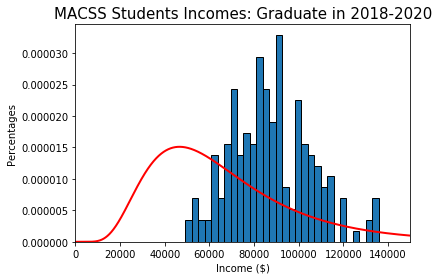

In [4]:
dist_pts = np.linspace(0, 150000, 5000)
mu_1 = 11
sigma_1 = 0.5

count, bins, ignored = plt.hist(incomes, 30, edgecolor='black', normed=True)
plt.title('MACSS Students Incomes: Graduate in 2018-2020', fontsize=15)
plt.xlabel('Income ($)')
plt.ylabel('Percentages')
plt.xlim([0, 150000])
plt.plot(dist_pts, truncnorm_pdf(dist_pts, mu_1, sigma_1, 150000),linewidth=2, \
         color='r', label='$\mu$=11,$\sigma$=0.5')
plt.show()

In [5]:
def log_lik_truncnorm(xvals, mu, sigma, cutoff):
    pdf_vals = truncnorm_pdf(xvals, mu, sigma, cutoff)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

In [6]:
LLV = log_lik_truncnorm(incomes, mu_1, sigma_1, 150000)
print("The log likelihood value is: ", LLV)

The log likelihood value is:  -2385.856997808558


(c) Estimate the parameters of the lognormal distribution by maximum likeli- hood and plot its PDF against the PDF from part (b) and the histogram from part (a). Plot the estimated PDF for 0 ≤ x ≤ 150, 000. Report the ML estimates for μ and σ, the value of the likelihood function, and the variance-covariance matrix.

In [7]:
def crit(params, *args):
    mu, sigma = params
    xvals, cutoff = args
    log_lik_val = log_lik_truncnorm(xvals, mu, sigma, cutoff)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [8]:
import scipy.optimize as opt

mu_init = 11 
sig_init = 0.5 
params_init = np.array([mu_init, sig_init])
mle_args = (incomes, 150000)
results = opt.minimize(crit, params_init, args=(mle_args), method='L-BFGS-B',
                       bounds=((0.1, None), (0.1, None)))
mu_MLE, sig_MLE = results.x
OffDiagNeg = np.array([[1, -1], [-1, 1]])
vcv_mle = results.hess_inv * OffDiagNeg
log_likelihood_MLE = log_lik_truncnorm(incomes, mu_MLE, sig_MLE, 150000)
print('mu_MLE=', mu_MLE, ' sig_MLE=', sig_MLE)
print('The log likelihood value of MLE is', log_likelihood_MLE)
print('Variance-Covariance matrix of MLE = ', vcv_mle)

mu_MLE= 11.359024408342044  sig_MLE= 0.2081785308159944
The log likelihood value of MLE is -2241.7193013686024
Variance-Covariance matrix of MLE =  [[ 0.00022522 -0.00022522]
 [-0.00010284  0.00010284]]


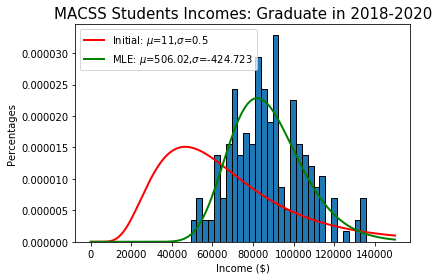

In [9]:
count, bins, ignored = plt.hist(incomes, 30, edgecolor='black', normed=True)
plt.title('MACSS Students Incomes: Graduate in 2018-2020', fontsize=15)
plt.xlabel('Income ($)')
plt.ylabel('Percentages')

# plot of (b)
plt.plot(dist_pts, truncnorm_pdf(dist_pts, mu_1, sigma_1, 150000),linewidth=2, \
         color='r', label='Initial: $\mu$=11,$\sigma$=0.5')

# Plot the MLE estimated distribution
plt.plot(dist_pts, truncnorm_pdf(dist_pts, mu_MLE, sig_MLE, 150000),
         linewidth=2, color='g', label='MLE: $\mu$=506.02,$\sigma$=-424.723')
plt.legend(loc='upper left')

(d) Perform a likelihood ratio test to determine the probability that the data came from the distribution in part (b).

In [10]:
log_lik_h0 = log_lik_truncnorm(incomes, mu_1, sigma_1, 150000)
log_lik_mle = log_lik_truncnorm(incomes, mu_MLE, sig_MLE, 150000)
LR_val = 2 * (log_lik_mle - log_lik_h0)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)
print('chi squared of H0 with 2 degrees of freedom p-value =', pval_h0)
print('So reject H0')

chi squared of H0 with 2 degrees of freedom p-value = 0.0
So reject H0


(e) 

In [11]:
high_income_prob = 1 - sts.lognorm.cdf(100000, sig_MLE, loc = 0, \
                                       scale = np.exp(mu_MLE))
low_income_prob = sts.lognorm.cdf(75000, sig_MLE, loc = 0, \
                                  scale = np.exp(mu_MLE))
print('The probability that earn more than $100,000 is : ', high_income_prob)
print('The probability that earn less than $75,000 is : ', low_income_prob)

The probability that earn more than $100,000 is :  0.22987019819533516
The probability that earn less than $75,000 is :  0.2602332804907479


## 2. Linear regression and MLE

(a)

In [12]:
import pandas as pd
sick_df = pd.read_csv('sick.txt')
sick_df.head()

,sick,age,children,avgtemp_winter
0,1.67,57.47,3.04,54.10
1,0.71,26.77,1.20,36.54
2,1.39,41.85,2.31,32.38
3,1.37,51.27,2.46,52.94
4,1.45,44.22,2.72,45.90


In [13]:
def log_lik_norm(xvals, sigma):
    pdf_vals = sts.norm.pdf(xvals, 0, sigma)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum() 
    return log_lik_val

def crit2(params, *args):
    b0, b1, b2, b3, sigma = params
    xvals = errors(args[0], b0, b1, b2, b3)
    log_lik_val = log_lik_norm(xvals, sigma)
    neg_log_lik_val = -log_lik_val
    return neg_log_lik_val

def errors(sick_df, b0, b1, b2, b3):
    e = sick_df['sick'] - b0 - b1 * sick_df['age'] - b2 * sick_df['children'] -\
    b3 * sick_df['avgtemp_winter']
    return pd.DataFrame(e)

In [14]:
params_init = np.array([0,0,0,0,1])
mle_args = (sick_df,)
results = opt.minimize(crit2, params_init, args=(mle_args))
b0, b1, b2, b3, mle_sigma = results.x
LLV_MLE = log_lik_norm(errors(mle_args[0], b0, b1, b2, b3), mle_sigma)
print('beta 0 is: ', b0)
print('beta 1 is: ', b1)
print('beta 2 is: ', b2)
print('beta 3 is: ', b3)
print('sigma is: ', mle_sigma)
print('sigma squared is: ', mle_sigma**2)
print('Log likelihood (MLE) is: ', LLV_MLE)


beta 0 is:  0.2516466612756078
beta 1 is:  0.012933371741520653
beta 2 is:  0.4005018454646766
beta 3 is:  -0.009991690492161316
sigma is:  0.0030177193758039963
sigma squared is:  9.10663023110286e-06
Log likelihood (MLE) is:  876.8650465192925


In [15]:
# np.eye(): 2-D array with ones on the diagonal and zeros elsewhere
# np.eye(5)*2-1 : 2-D array with ones on the diagonal and -1 elsewhere
OffDiagNeg = np.eye(5)*2-1
vcv_mle = results.hess_inv * OffDiagNeg
print()
print('VCV(MLE) = ', vcv_mle)


VCV(MLE) =  [[ 9.00941090e-07 -1.16801251e-08  2.01374031e-07  2.27910168e-08
  -3.06113586e-09]
 [-1.16801251e-08  3.89127324e-09  3.42324355e-08  2.55217326e-09
   2.60137822e-11]
 [ 2.01374031e-07  3.42324355e-08  3.54151265e-07 -2.26547607e-08
   1.25281148e-09]
 [ 2.27910168e-08  2.55217326e-09 -2.26547607e-08  2.01788839e-09
   1.73988972e-11]
 [-3.06113586e-09  2.60137822e-11  1.25281148e-09  1.73988972e-11
   2.31132728e-08]]


(b) 

In [16]:
log_lik_h0 = log_lik_norm(errors(sick_df,1,0,0,0), 0.1)
log_lik_mle = log_lik_norm(errors(sick_df,b0,b1,b2,b3),mle_sigma)
LR_val = 2 * (log_lik_mle - log_lik_h0)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)
print('chi squared of H0 with 2 degrees of freedom p-value = ', pval_h0)
print('So reject H0')

chi squared of H0 with 2 degrees of freedom p-value =  0.0
So reject H0
